In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import seaborn as sns
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

/home/jakob/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Welcome to JupyROOT 6.26/04


In [2]:
sigma_df=pd.read_csv('sigma.csv',index_col=0)
alt_sigma_df=pd.read_csv('alt_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('diagnostics.csv',index_col=0)
alt_diagnostics_df=pd.read_csv('alt_diagnostics.csv',index_col=0)

sigma_unbinned_df=pd.read_csv('../../RooFit/sigma_unbinned_fit.txt',sep='\t')
df_bkg=pd.read_csv('./2pi0_bkg_costp.txt',sep=',',index_col=0)
df_fr=pd.read_csv('./new_2pi0_bkg_fr.txt',sep=',',index_col=0)
df_fr_total=pd.read_csv('./total_bkg_fr.txt',sep=',',index_col=0)
cols=['costheta','sigma','sigma_err']
collins_1569_df=pd.read_csv('../../prev_results/collins_1569.txt',sep=' ',header=None,names=cols)
collins_1676_df=pd.read_csv('../../prev_results/collins_1676.txt',sep=' ',header=None,names=cols)
collins_1729_df=pd.read_csv('../../prev_results/collins_1729.txt',sep=' ',header=None,names=cols)
pwa_1550_df=pd.read_csv('../../etap_PWA/etaMAID_1550.csv', sep=',')
pwa_1650_df=pd.read_csv('../../etap_PWA/etaMAID_1650.csv', sep=',')
pwa_1750_df=pd.read_csv('../../etap_PWA/etaMAID_1750.csv', sep=',')


pwa=[pwa_1550_df,pwa_1650_df,pwa_1750_df]
for df in pwa:
    df.columns=['W','Theta','cosTheta','-t','dcs','ds/dt','T','F','Sigma','E','G','H','P','dcs_1/2','dcs_3/2']
collins=[collins_1569_df,collins_1676_df,collins_1729_df]

In [44]:
pwa[2]

W  Theta  cosTheta      -t      dcs     ds/dt        T        F  \
0   2040.56    0.0    1.0000  0.1322  0.00987  0.102195  0.00000  0.00000   
1   2040.56    2.0    0.9994  0.1326  0.01031  0.106804  0.19738 -0.13762   
2   2040.56    4.0    0.9976  0.1337  0.01164  0.120514  0.35565 -0.24330   
3   2040.56    6.0    0.9945  0.1355  0.01381  0.142975  0.46159 -0.30631   
4   2040.56    8.0    0.9903  0.1381  0.01677  0.173616  0.52449 -0.33439   
..      ...    ...       ...     ...      ...       ...      ...      ...   
86  2040.56  172.0   -0.9903  1.3399  0.00307  0.031830 -0.57320  0.23406   
87  2040.56  174.0   -0.9945  1.3425  0.00221  0.022906 -0.57134  0.19256   
88  2040.56  176.0   -0.9976  1.3443  0.00159  0.016494 -0.51040  0.14370   
89  2040.56  178.0   -0.9994  1.3454  0.00122  0.012631 -0.32560  0.08011   
90  2040.56  180.0   -1.0000  1.3458  0.00110  0.011341  0.00000  0.00000   

      Sigma        E        G        H        P  dcs_1/2  dcs_3/2  
0   0.00000  1.00000  0.00000  0.00000  0.00000  0.01974  0.00000  
1   0.00242  0.97005  0.03151  0.14197 -0.14158  0.02032  0.00031  
2   0.00851  0.89479  0.11047  0.25288 -0.25013  0.02205  0.00122  
3   0.01595  0.80353  0.20568  0.32226 -0.31459  0.02490  0.00271  
4   0.02294  0.71854  0.29338  0.35753 -0.34297  0.02881  0.00472  
..      ...      ...      ...      ...      ...      ...      ...  
86  0.12068  0.62640 -0.45053  0.15847  0.13554  0.00500  0.00115  
87  0.09524  0.70279 -0.36199  0.09745  0.08378  0.00377  0.00066  
88  0.05918  0.81421 -0.22788  0.04431  0.03862  0.00289  0.00030  
89  0.01940  0.93888 -0.07528  0.01064  0.00970  0.00237  0.00007  
90  0.00000  1.00000  0.00000  0.00000  0.00000  0.00219  0.00000  

[91 rows x 15 columns]

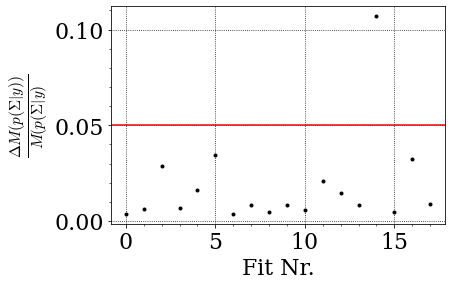

In [3]:
fig, ax = plt.subplots()
ax.plot(np.arange(18),np.abs(np.array(alt_diagnostics_df.loc[['mcse']])[0]/np.array(alt_diagnostics_df.loc[['sigma_median']])[0]),'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
#ax.set_ylim([0,0.5])
ax.axhline(y=0.05,color='red')
plt.show()
fig.savefig('./plots/mcse.pdf',format='pdf',bbox_inches='tight',dpi=1000)

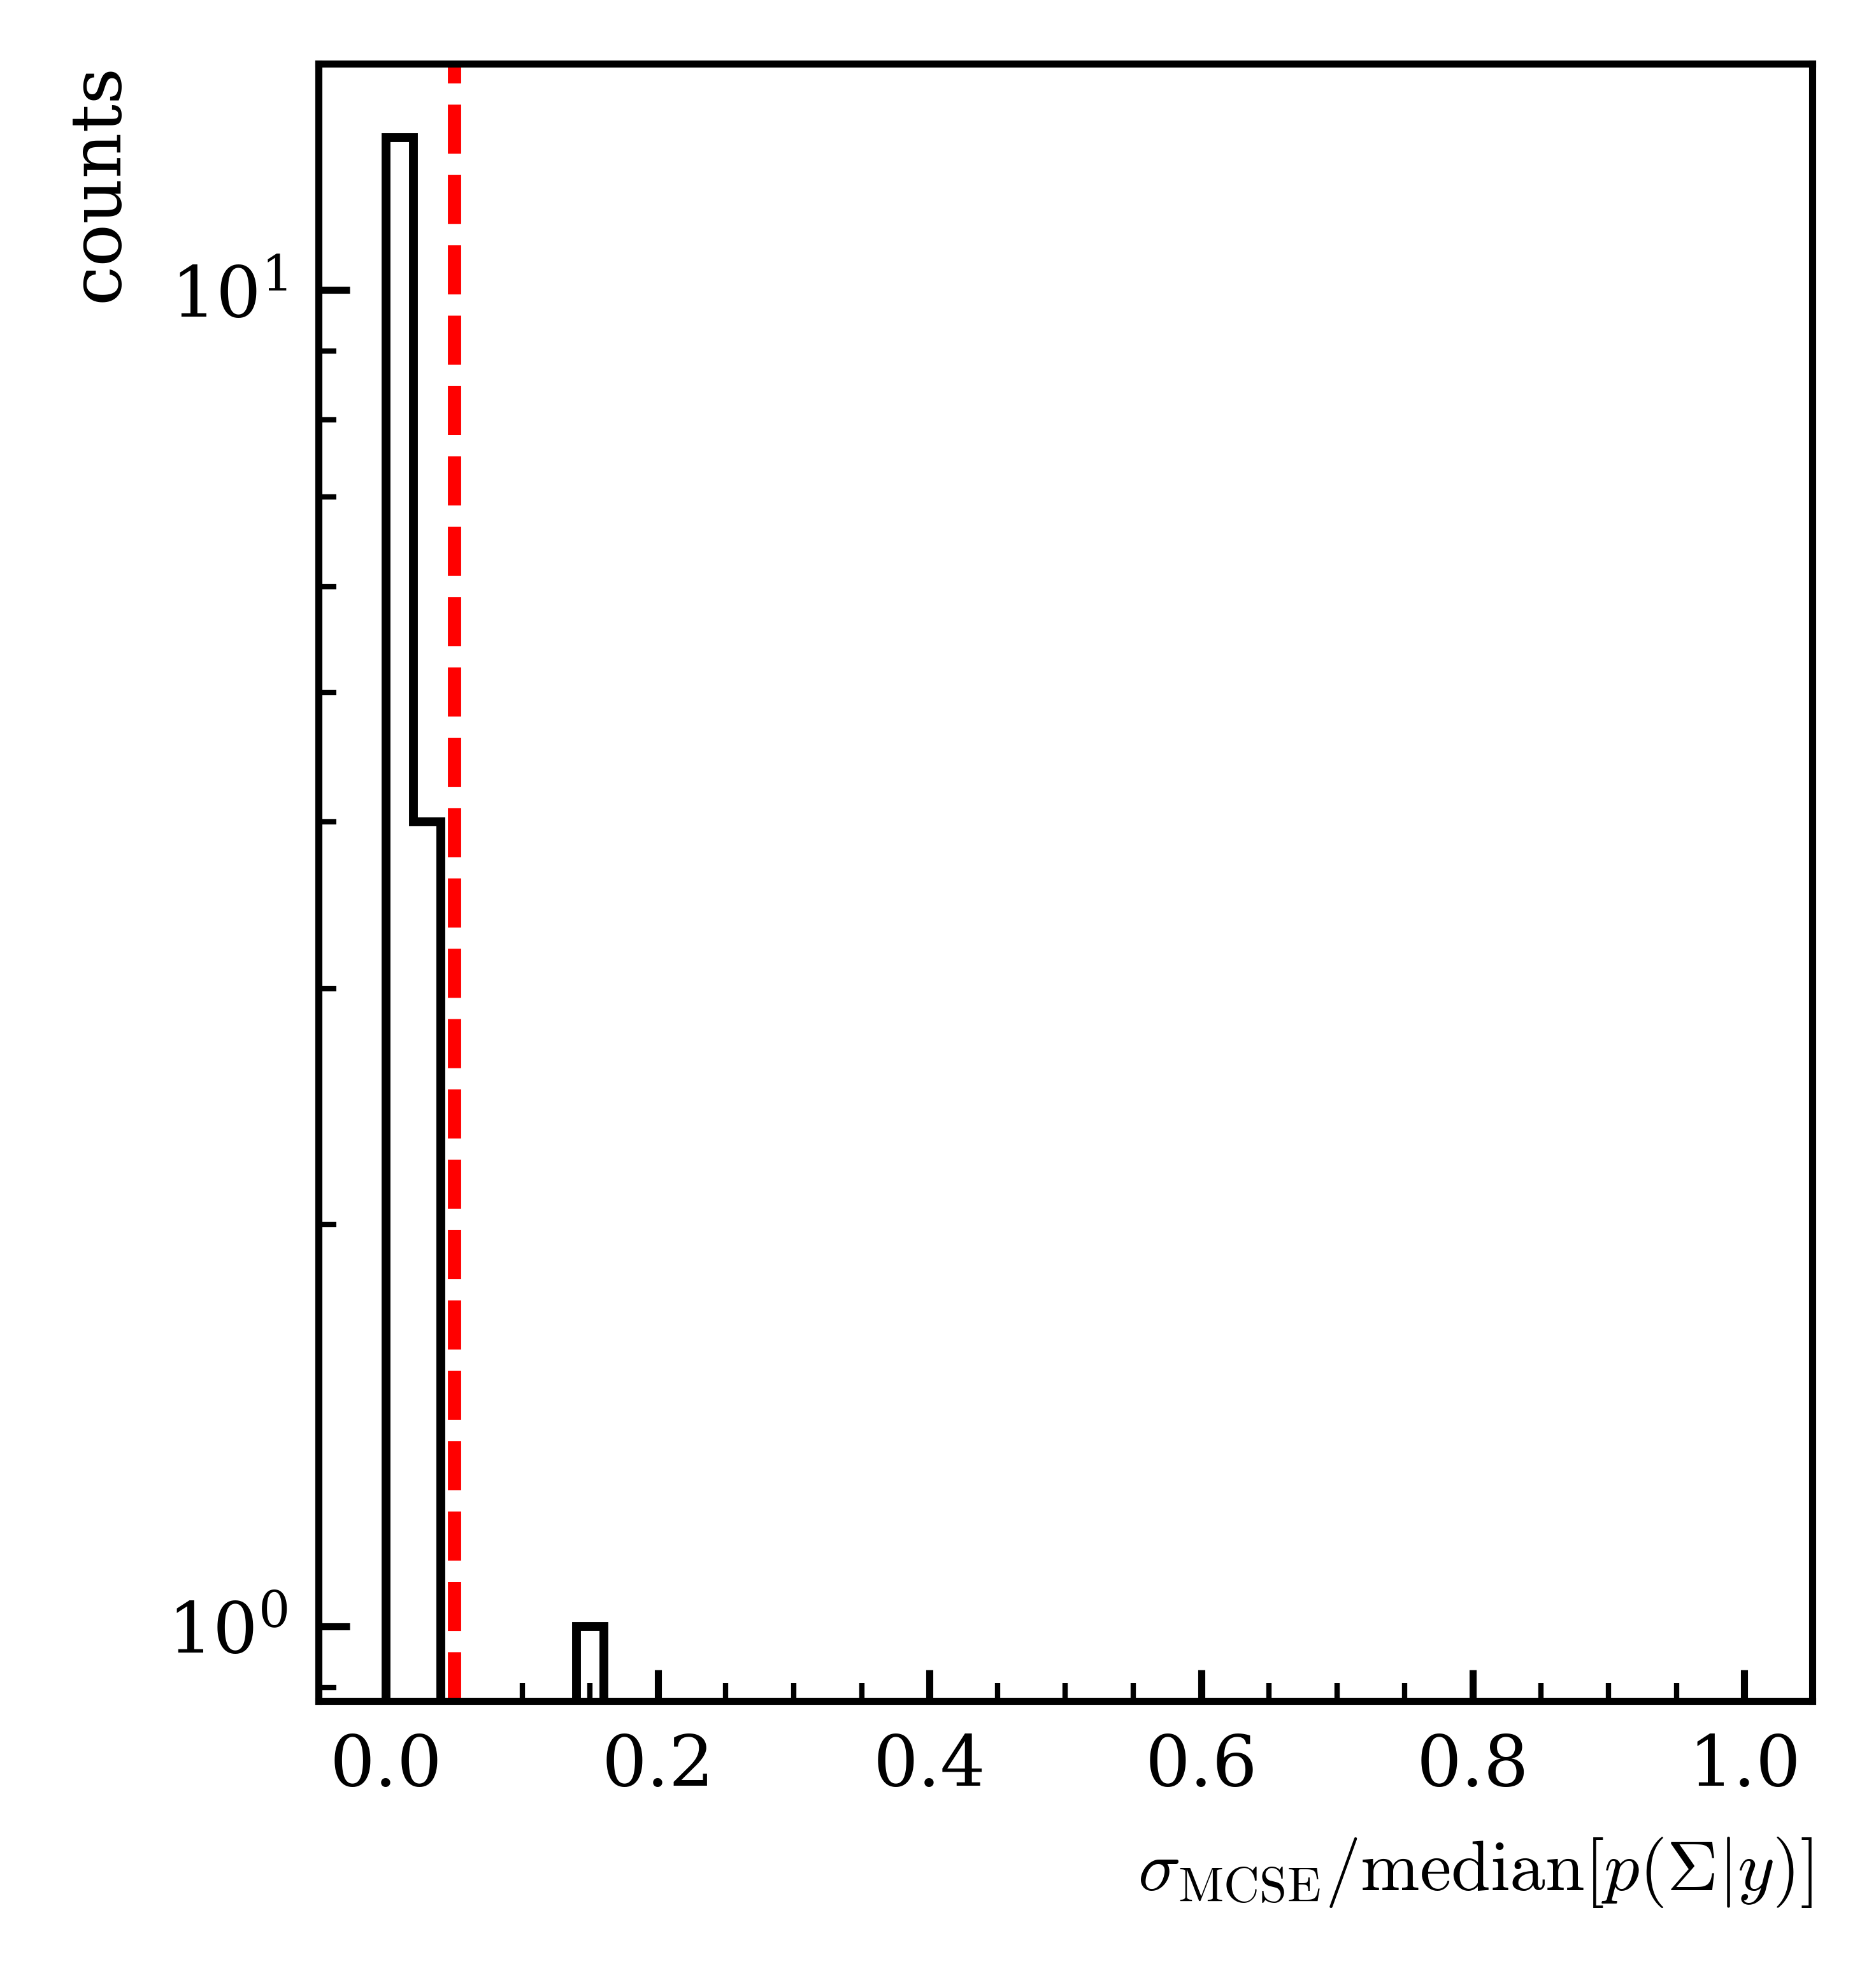

In [4]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values)),histtype='step',log=True,range=[0,1],bins=50)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=0.05,color='red',linestyle='--')
ax.grid(False)
ax.tick_params(axis='both',which='both',direction='in')
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

In [4]:
for col in alt_sigma_df.columns:
    data = [alt_sigma_df[col].values[i*5000:(i+1)*5000] for i in range(4)]
    #print(data)
    rhat = az.rhat(np.array(data))
    diagnostics_df[col]['rhat']=rhat

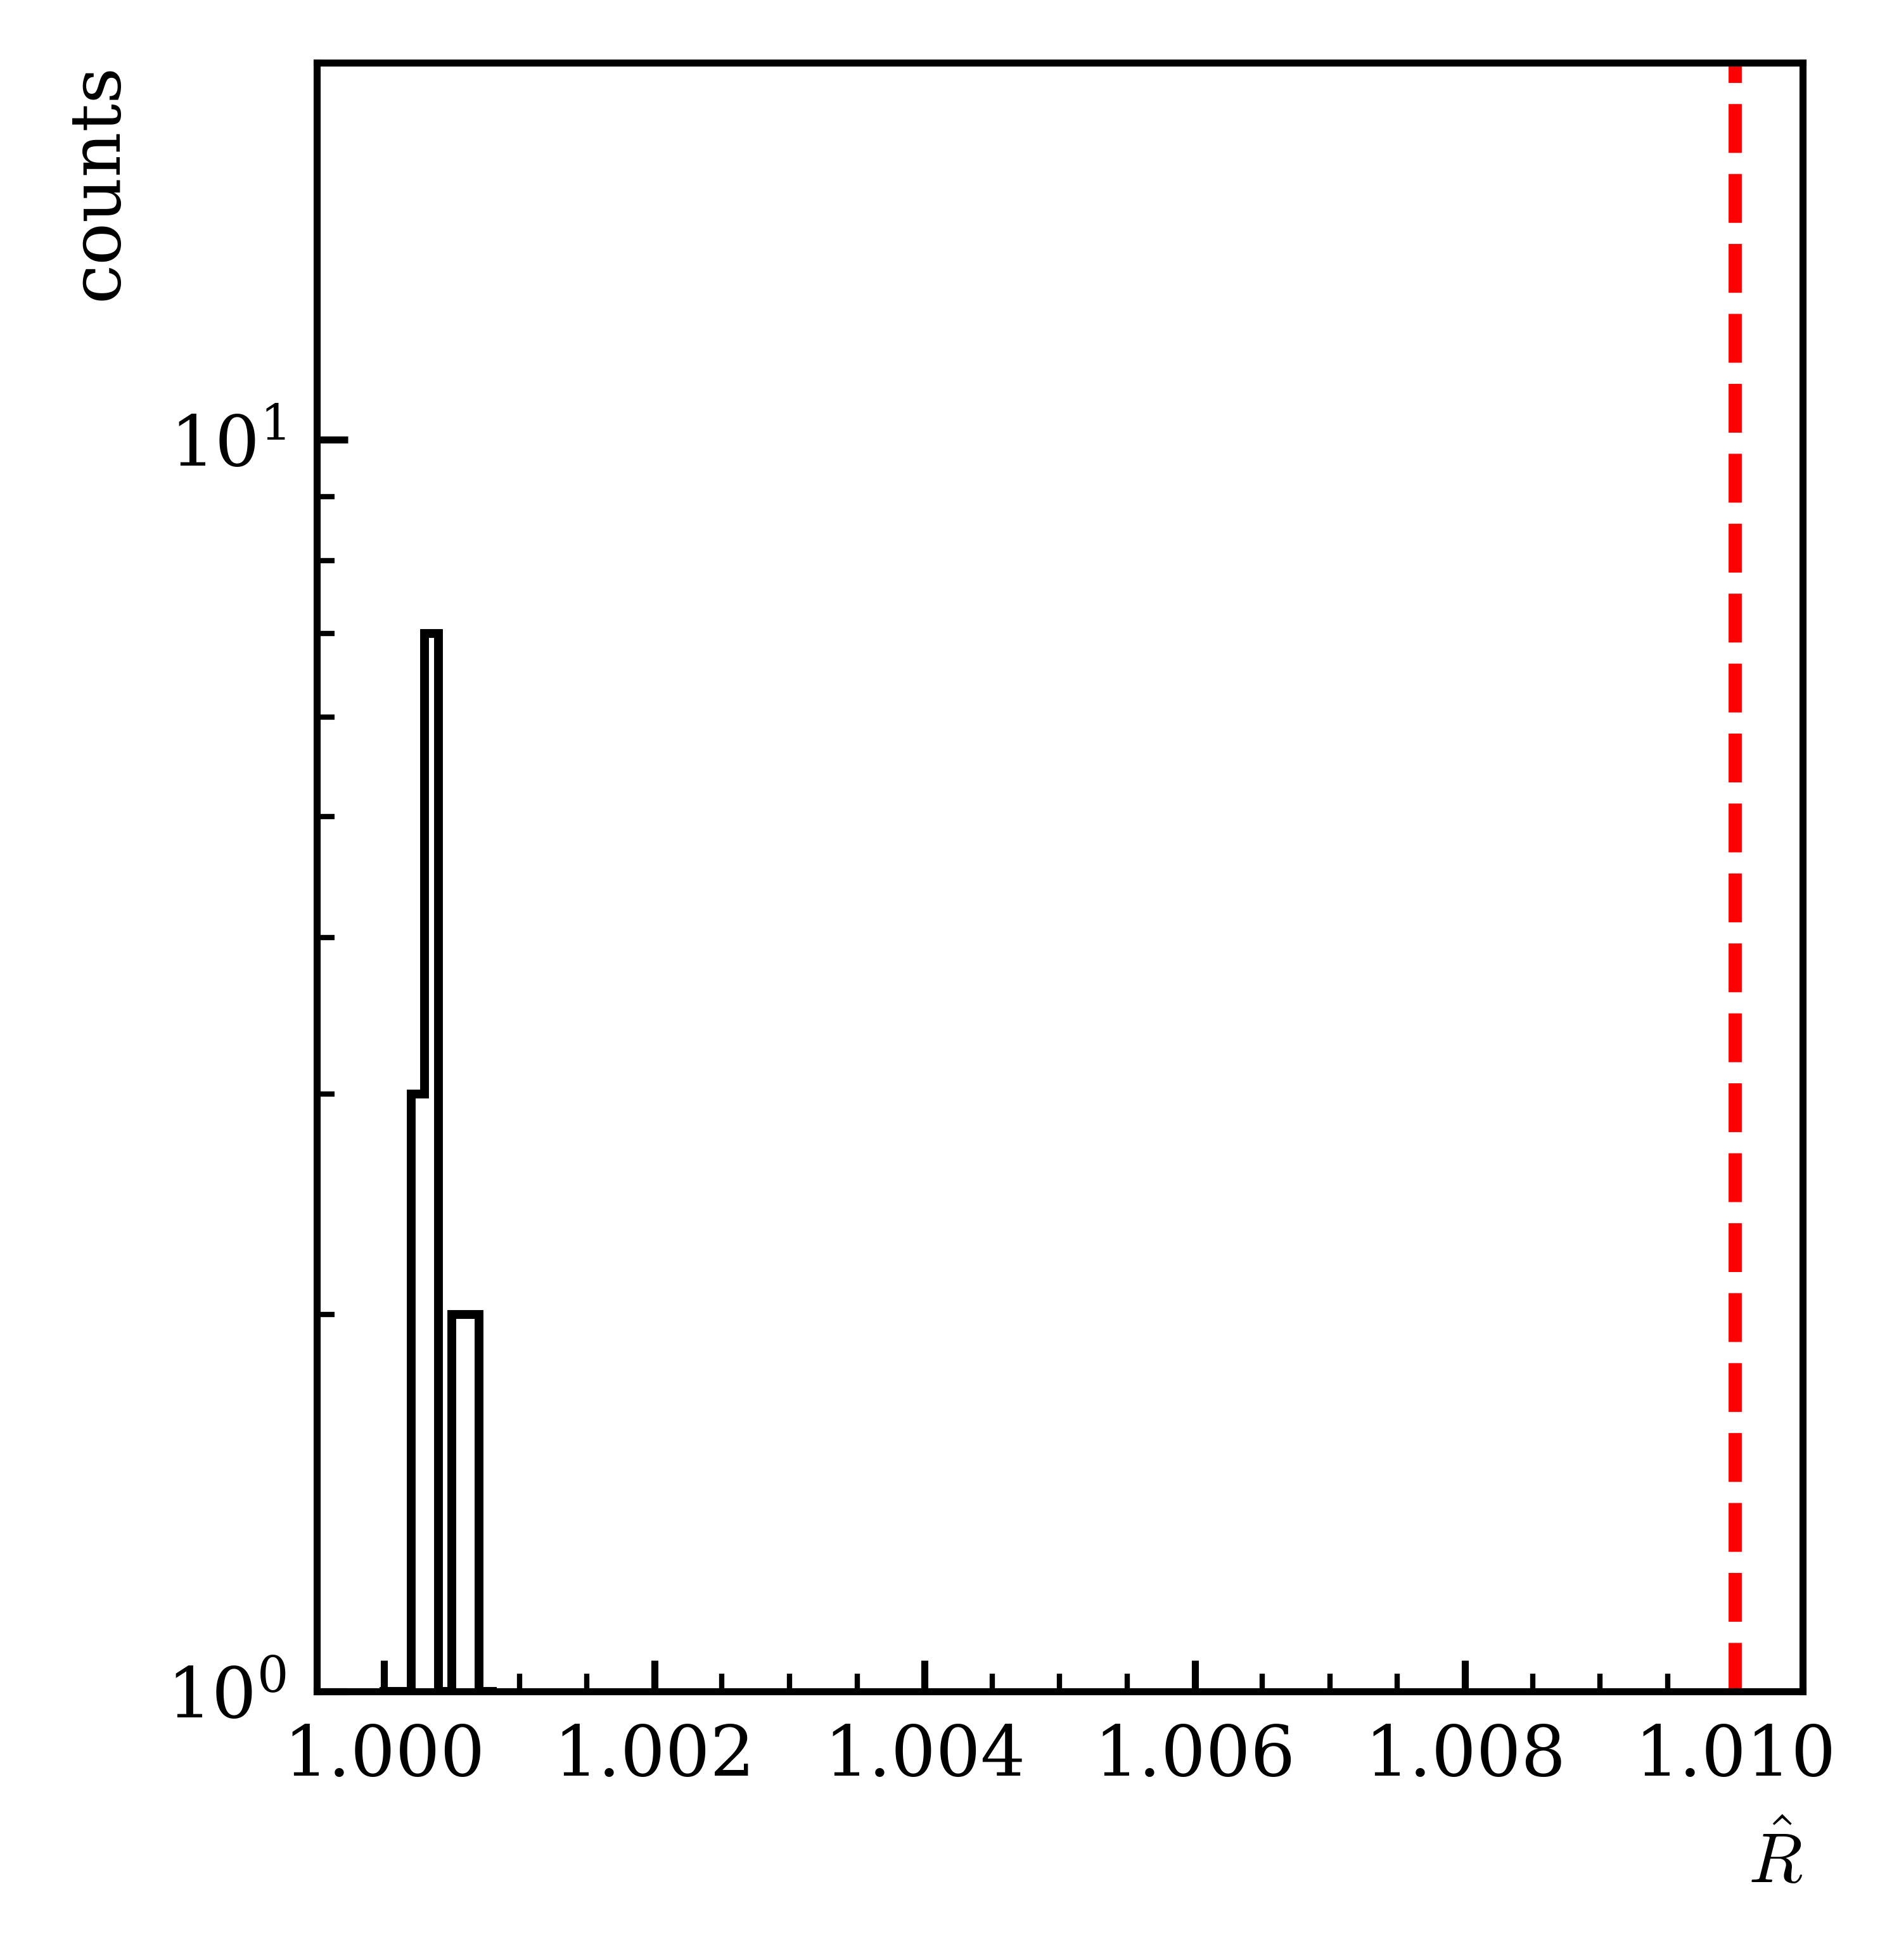

In [5]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)
ax.tick_params(axis='both',which='both',direction='in')
ax.hist(diagnostics_df.loc['rhat'].values,histtype='step',log=True,range=([1.00,1.01]),bins=100)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\hat{R}$',horizontalalignment='right',x=1.0)
#ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.set_ylim([1e0,2e2])
ax.axvline(x=1.01,color='red',linestyle='--')
ax.grid(False)
ax.set_ylim([1e0,2e1])
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/rhat_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

In [7]:
sigma_unbinned_df

egamma  costheta     sigma  sigma_err
0     1550 -0.833333 -0.741309   0.309948
1     1550 -0.500000 -0.328640   0.297251
2     1550 -0.166667 -0.071521   0.281409
3     1550  0.166667 -0.324256   0.273867
4     1550  0.500000 -0.115293   0.279513
5     1550  0.833333 -0.078044   0.325741
6     1650 -0.833333 -0.611289   0.258925
7     1650 -0.500000 -0.214957   0.230938
8     1650 -0.166667 -0.317616   0.202621
9     1650  0.166667  0.169137   0.195490
10    1650  0.500000 -0.258178   0.191327
11    1650  0.833333  0.057574   0.231196
12    1750 -0.833333  0.209021   0.378862
13    1750 -0.500000  0.228460   0.307949
14    1750 -0.166667  0.012835   0.264703
15    1750  0.166667 -0.501859   0.249724
16    1750  0.500000  0.056813   0.248385
17    1750  0.833333 -0.220003   0.279441

In [7]:
fracs=[]
counter=0
for col in sigma_df.columns:
    sigma_dist=np.array(sigma_df[col].values)
    if np.isnan(np.sum(sigma_dist)):
        continue
    sigma_chi2, err_chi2 =sigma_unbinned_df['sigma'][counter], sigma_unbinned_df['sigma_err'][counter]
    lower=sigma_chi2-err_chi2
    upper=sigma_chi2+err_chi2
    frac=len(sigma_dist[(sigma_dist>lower) & (sigma_dist<upper)])/len(sigma_dist)
    #frac=np.std(sigma_dist)/err_chi2
    fracs.append(frac)
    counter+=1

In [8]:
np.mean(fracs)

0.7063888888888888

In [16]:
counter=1
fr=np.array([df_fr[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])
fr_sys=np.array([df_fr_total[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])-fr

np.max(fr_sys)

0.13

In [9]:
def plot_sigma(which='both',sys=False,show_pwa=False,data=False,saveas=''):
    plt.rcParams['font.size']=8
    plt.rcParams['axes.grid']=False
    fig,ax = plt.subplots(3,1,sharey='col',dpi=1000,figsize=[15.3728/2.54,0.8*21.41492/2.54])
    plt.subplots_adjust(wspace=0, hspace=0)
    counter=0
    for i in range(1):
        for j in range(3):
            if(j==0 and i==0):
                ax[j].set_ylabel('$\Sigma$',horizontalalignment='right',y=1.0)
            if(j==2):
                ax[j].set_xlabel('$\cos\\theta_{\eta\'}^{\mathrm{CMS}}$',horizontalalignment='right',x=1.0)
            ax[j].set_xlim([-1.2,1.2])
            ax[j].set_ylim([-1.5,1.5])
            ax[j].tick_params(axis='both',which='both',direction='in')
            #binning in costheta
            x=[-1+2/6/2+(i)*2/6 for i in range(6)]

            if(counter<11):

                #get sigma 2pi0 and fraction in current ebin
                #sigma
                sigma_2pi0=-1*np.array([df_bkg[f"ebin{counter:02d}costbin{-j+5:02d}"]['sigma'] for j in range(6)])
                #error
                sigma_2pi0_err=np.array([df_bkg[f"ebin{counter:02d}costbin{-j+5:02d}"]['sigma_err'] for j in range(6)])
                #bkg fraction
                fr=np.array([df_fr[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])

                #sigma_meas=a*sigma_true+b*sigma_bkg
                sigma_meas=np.array(sigma_unbinned_df['sigma'][counter*6:counter*6+6])
                sigma_true=(sigma_meas-fr*sigma_2pi0)/(1-fr)
                
                #correct errors
                old_err=np.array(sigma_unbinned_df['sigma_err'][counter*6:counter*6+6])
                err_true=np.sqrt(((old_err)/(1-fr))**2
                            +(sigma_2pi0_err*fr/(1-fr))**2)
                #either plot both estimates...
                if(which=='both'):
                    #plot point estimates from event based fit
                    ax[j].errorbar(x=x,y=sigma_unbinned_df['sigma'][counter*6:counter*6+6],
                              yerr=sigma_unbinned_df['sigma_err'][counter*6:counter*6+6],
                              fmt='v',markersize=4.,color='darkorange',label='Event based fit')
                    #plot corrected point estimates
                    ax[j].errorbar(x=x,y=sigma_true,
                              yerr=err_true,
                              fmt='v',markersize=4.,color='peachpuff',label='Event based fit (alt)')
                    #plot sigma posterior obtained from event based fit
                    vp=ax[j].violinplot([sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                    showmeans=False, showextrema=False, showmedians=False,widths=0.5)
                    #plot alt results considering bkg contributions
                    vp_alt=ax[j].violinplot([alt_sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.5)
                    #cosmetics
                    for b in vp['bodies']:
                        # get the center
                        m = np.mean(b.get_paths()[0].vertices[:, 0])
                        # modify the paths to not go further right than the center
                        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                        b.set_alpha(.5)
                        b.set_color('navy')
                    for b in vp_alt['bodies']:
                        # get the center
                        m = np.mean(b.get_paths()[0].vertices[:, 0])
                        # modify the paths to not go further right than the center
                        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                        b.set_alpha(.1)
                        b.set_color('navy')
                #... or only corrected estimates
                else:
                    #plot corrected point estimates
                    ax[j].errorbar(x=x,y=sigma_true,
                              yerr=err_true,
                              fmt='v',markersize=4.,color='darkorange',label='Event based fit (alt)')
                    vp_alt=ax[j].violinplot([alt_sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.5)
                    #cosmetics
                    for b in vp_alt['bodies']:
                        # get the center
                        m = np.mean(b.get_paths()[0].vertices[:, 0])
                        # modify the paths to not go further right than the center
                        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                        b.set_alpha(.5)
                        b.set_color('navy')
                #plot systematic errors
                #neglected bkg fraction
                fr_sys=np.array([df_fr_total[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])-fr
                #systematic deviation with neglected bkg
                sigma_sys_dev_low=np.abs(sigma_true-(sigma_meas-fr*sigma_2pi0-fr_sys)/(1-fr-fr_sys))
                sigma_sys_dev_up=np.abs(sigma_true-(sigma_meas-fr*sigma_2pi0+fr_sys)/(1-fr-fr_sys))
                #take only the maximum values
                sigma_sys_dev=np.maximum(sigma_sys_dev_low,sigma_sys_dev_up)
                if j==0:
                    r=0.05
                else:
                    r=0.08
                sigma_sys_pol=r*sigma_true
                sigma_sys_err=np.sqrt(sigma_sys_dev**2+sigma_sys_pol**2)
                err_true=np.sqrt(sigma_sys_err**2+err_true**2)
                
                #print(fr_sys)
                if(sys):
                    ax[j].bar(x=x,height=sigma_sys_err,bottom=-1.5,width=1/3,color='gray')

                #compare with collins results
                if(data):
                    ax[j].errorbar(x=np.cos(np.array(collins[j]['costheta'])*np.pi/180.),y=collins[j]['sigma'],
                                  yerr=collins[j]['sigma_err'],
                                  fmt='s',markersize=4.,color='black',label='Collins et al.')
                if(show_pwa):
                    pwax=pwa[j]['cosTheta'].values
                    pway=pwa[j]['Sigma'].values
                    ax[j].plot(pwax,pway,'--',color='black')
                #title for each bin
                ax[j].text(0,1,f'${1500+counter*100}$ MeV $\leq E_\gamma < {1500+(counter+1)*100}$ MeV',
                       fontsize=8,ha='center',va='center')
            counter+=1
    lines,labels = ax[0].get_legend_handles_labels() 
    patch = mpatches.Patch(color='navy', label='bayesian fit (event based)',alpha=.5)
    patch1 = mpatches.Patch(color='navy', label='bayesian fit (event based alt)',alpha=.1)

    lines.append(patch)
    lines.append(patch1)

    #plt.legend(handles=lines,bbox_to_anchor=(1.4,-0.1))        
    plt.show()
    if(len(saveas)>2):
        fig.savefig(f'./plots/{saveas}.pdf',format='pdf',bbox_inches='tight',dpi=1000)


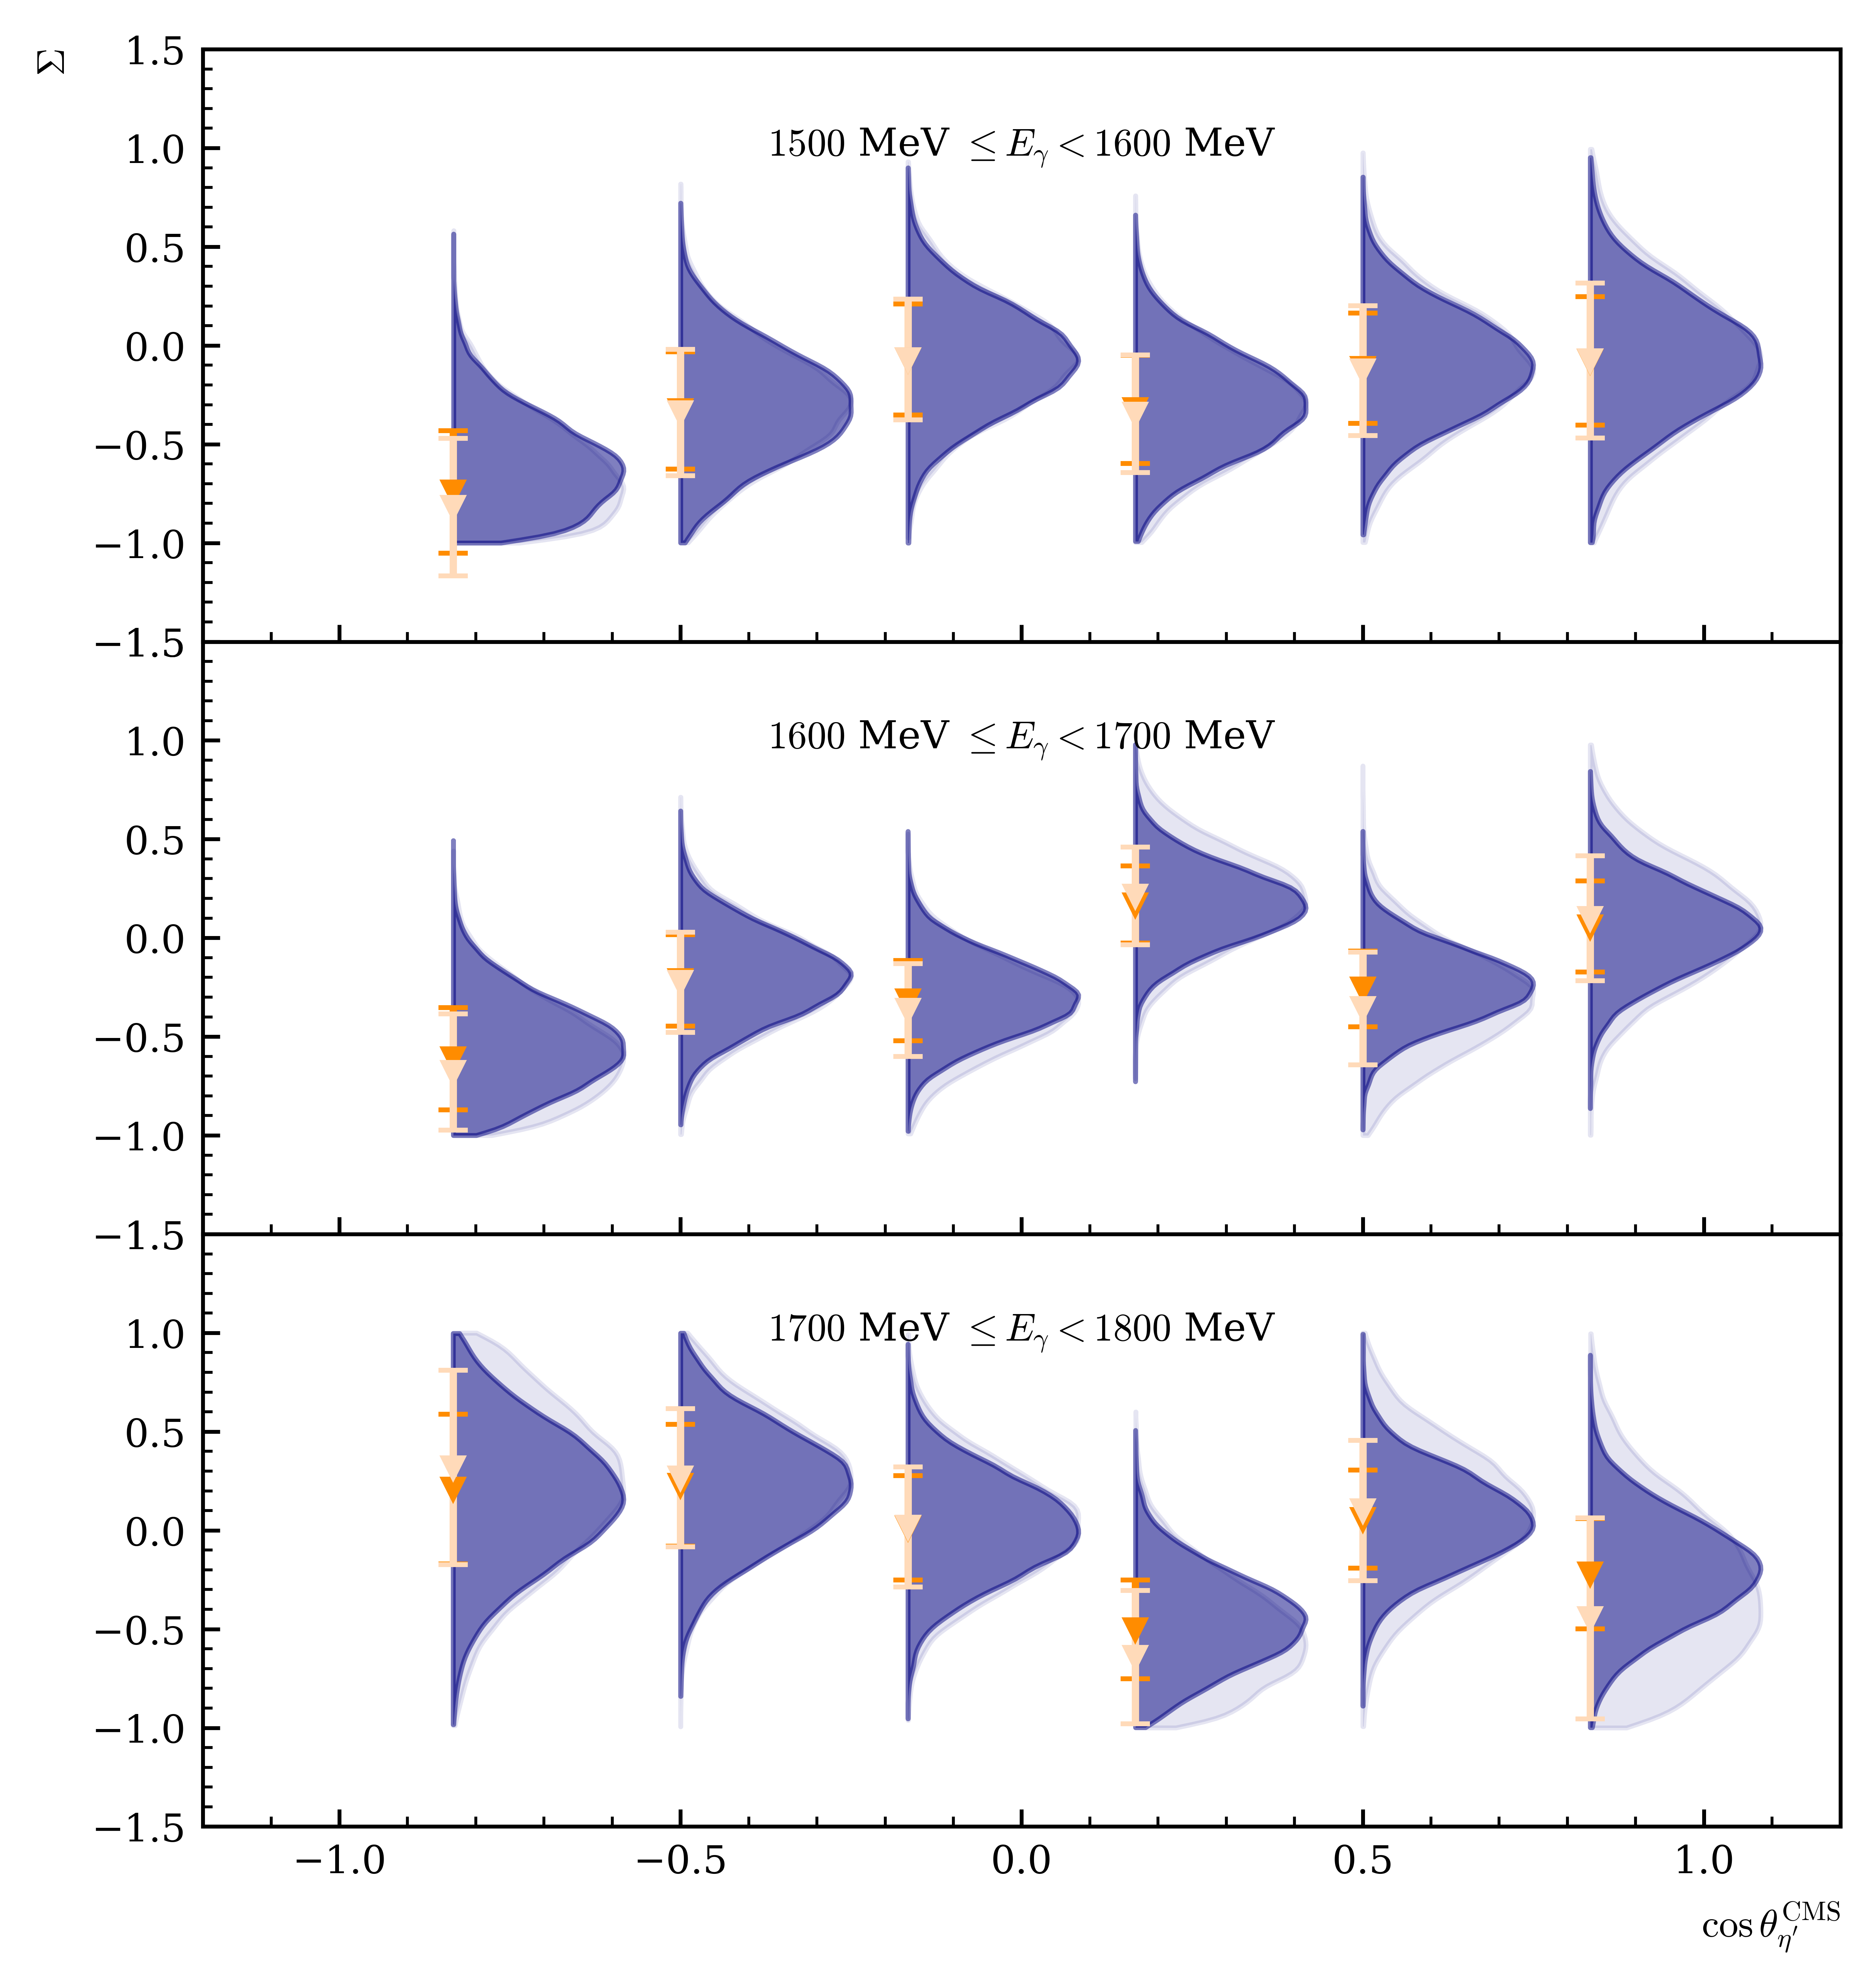

In [17]:
plot_sigma(which='both',data=False,show_pwa=False,sys=False,saveas='sigma_etap')

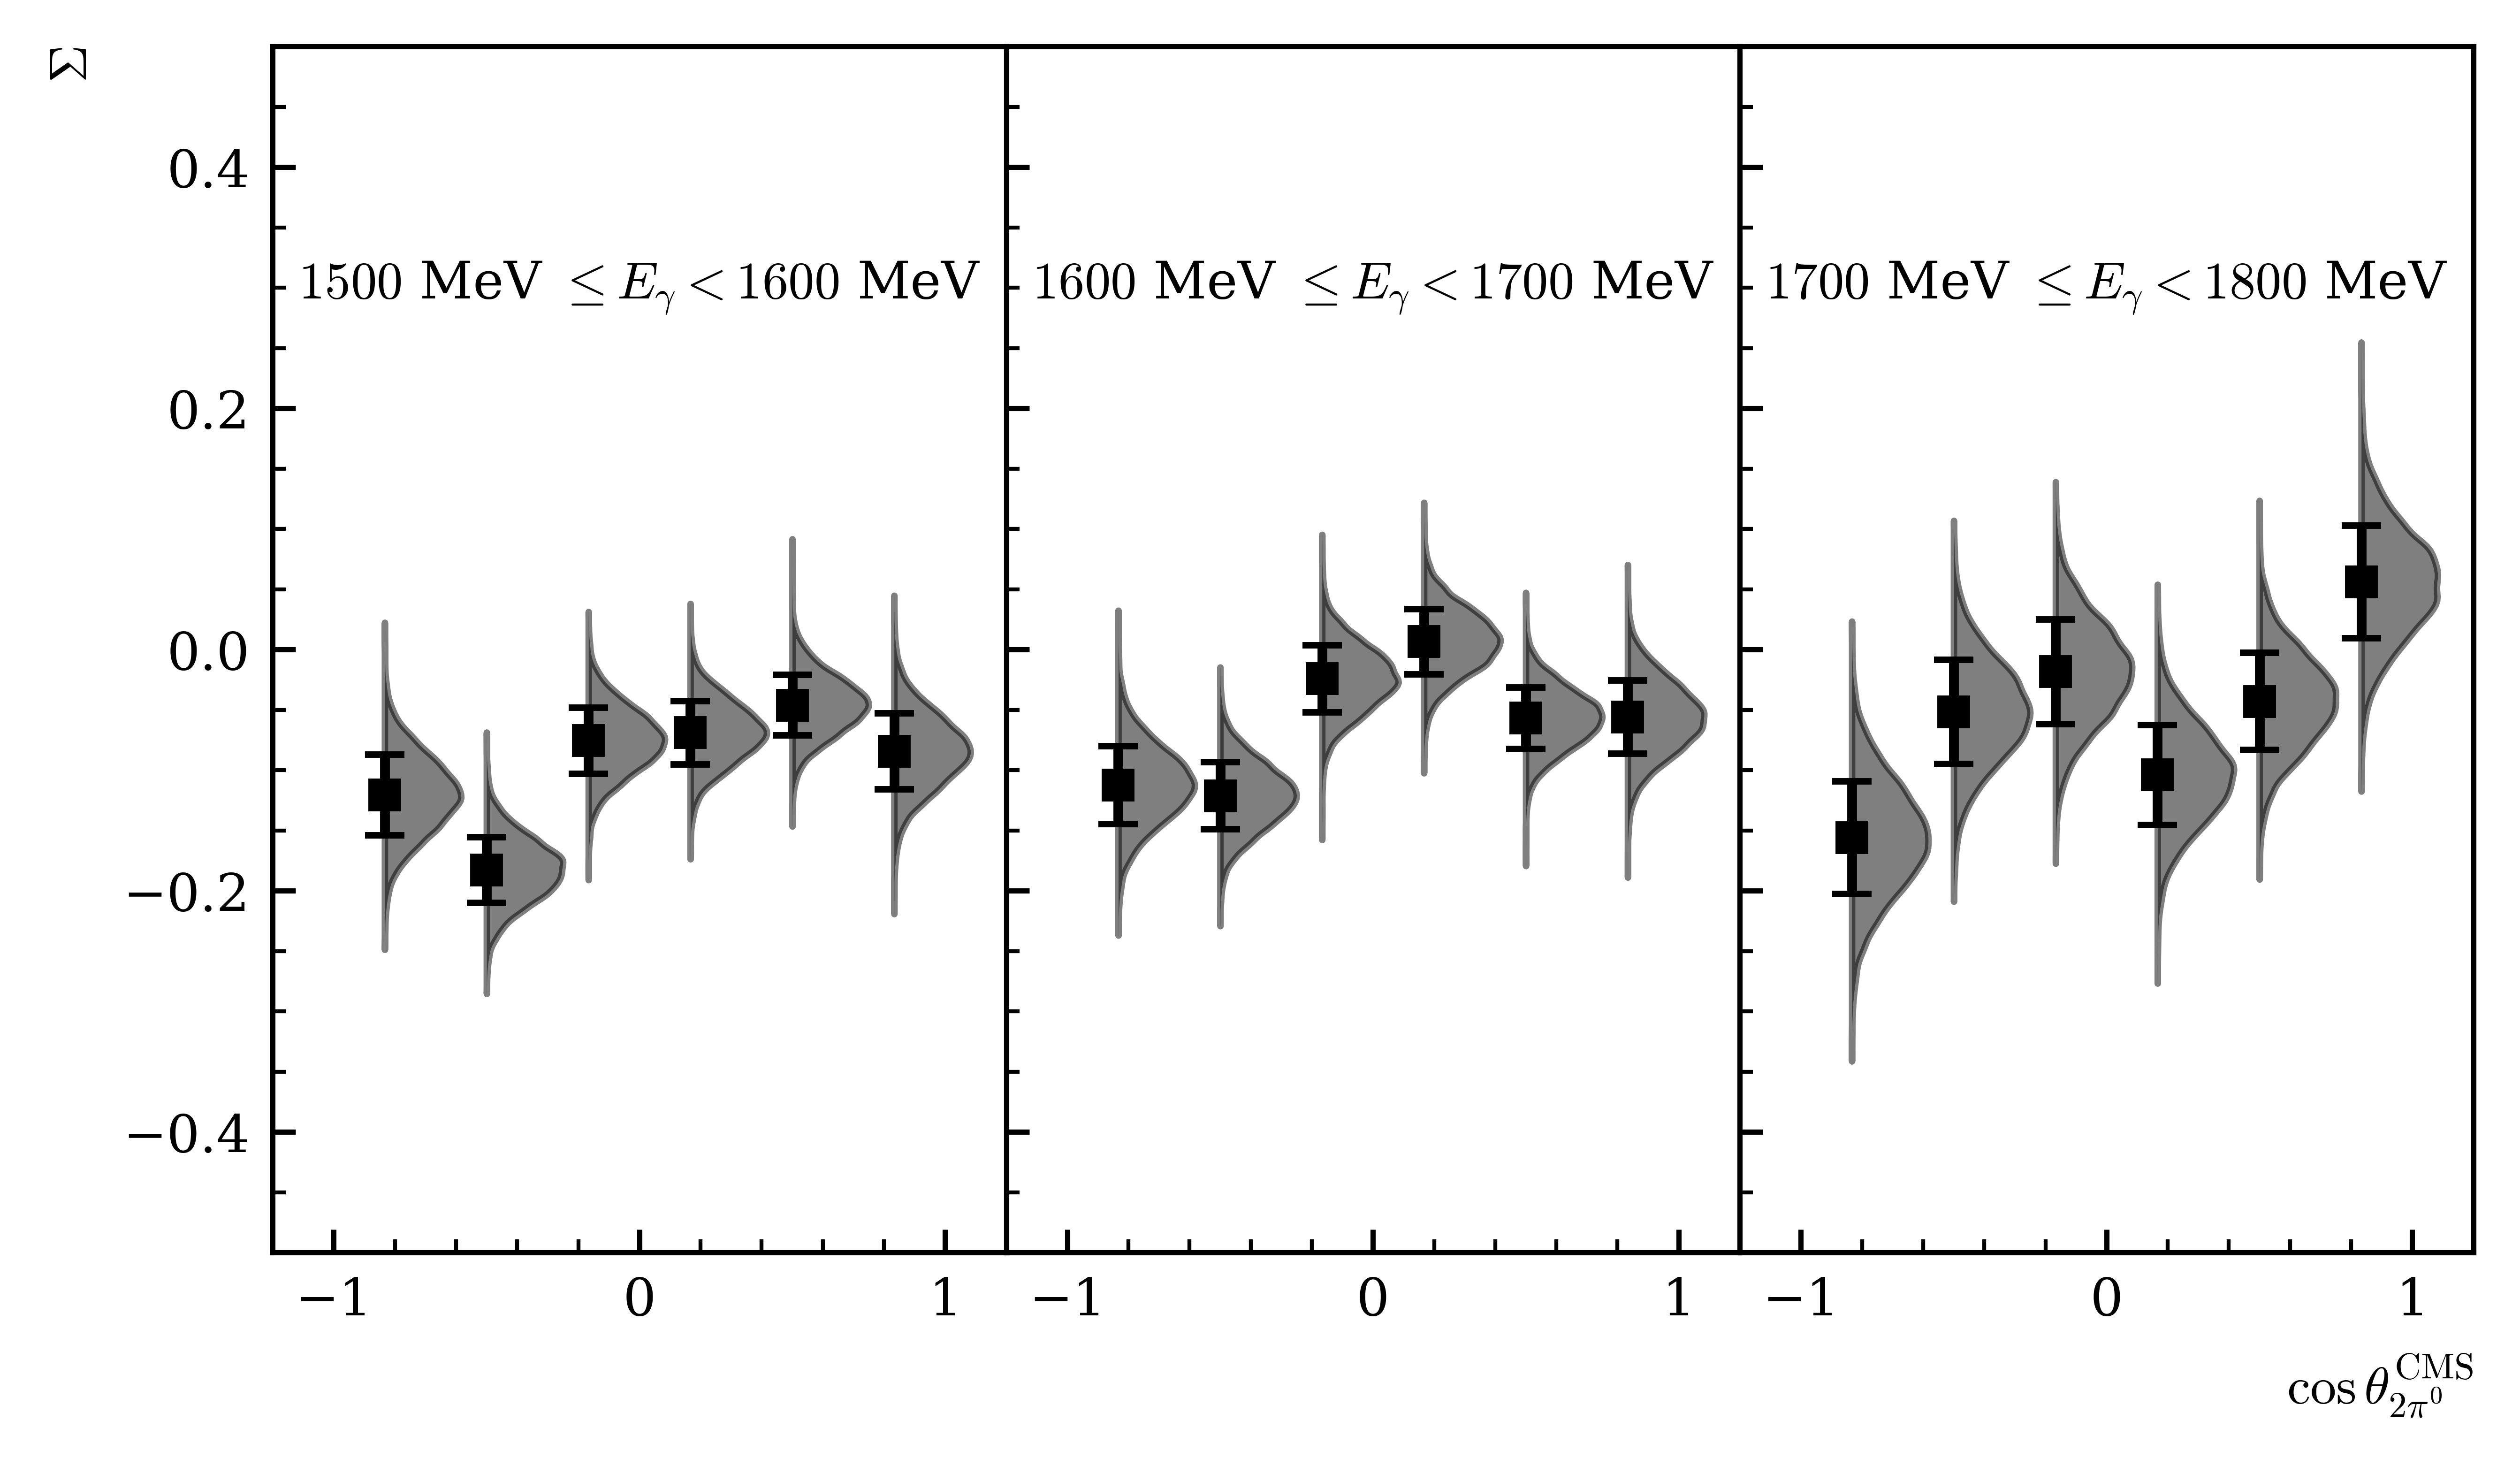

In [18]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
fig,ax = plt.subplots(1,3,sharey='row',dpi=1000,figsize=[15.3728/2.54,8.6472/2.54])
plt.subplots_adjust(wspace=0, hspace=0)
counter=0
sigma_2pi0_df=pd.read_csv('./sigma_2pi0.csv')
for i in range(1):
    for j in range(3):
        if(j==0 and i==0):
            ax[j].set_ylabel('$\Sigma$',horizontalalignment='right',y=1.0)
        if(j==2):
            ax[j].set_xlabel('$\cos\\theta_{2\pi^{0}}^{\mathrm{CMS}}$',horizontalalignment='right',x=1.0)
        ax[j].set_xlim([-1.2,1.2])
        ax[j].set_ylim([-0.5,0.5])
        ax[j].tick_params(axis='both',which='both',direction='in')

        x=[-1+2/6/2+(i)*2/6 for i in range(6)]
        #get sigma 2pi0 and fraction in current ebin
        #sigma
        sigma_2pi0=-1*np.array([df_bkg[f"ebin{counter:02d}costbin{-k+5:02d}"]['sigma'] for k in range(6)])
        #error
        sigma_2pi0_err=np.array([df_bkg[f"ebin{counter:02d}costbin{-k+5:02d}"]['sigma_err'] for k in range(6)])
        ax[j].errorbar(x=x,y=sigma_2pi0,yerr=sigma_2pi0_err,fmt='s',color='black',label='data (P. Mahlberg)',markersize=4)
        vp=ax[j].violinplot([sigma_2pi0_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.5)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('black')
        ax[j].text(0,0.3,f'${1500+counter*100}$ MeV $\leq E_\gamma < {1500+(counter+1)*100}$ MeV',
                       fontsize=8,ha='center',va='center')
        counter+=1
        lines,labels = ax[0].get_legend_handles_labels() 
        patch = mpatches.Patch(color='black', label='bayesian fit of $\Sigma_{\mathrm{bkg}}^{\mathrm{true}}$',alpha=.5)
        lines.append(patch)

        #plt.legend(handles=lines,bbox_to_anchor=(1.4,-0.1))
plt.show()
fig.savefig(f'./plots/sigma_2pi0.pdf',format='pdf',bbox_inches='tight',dpi=1000)


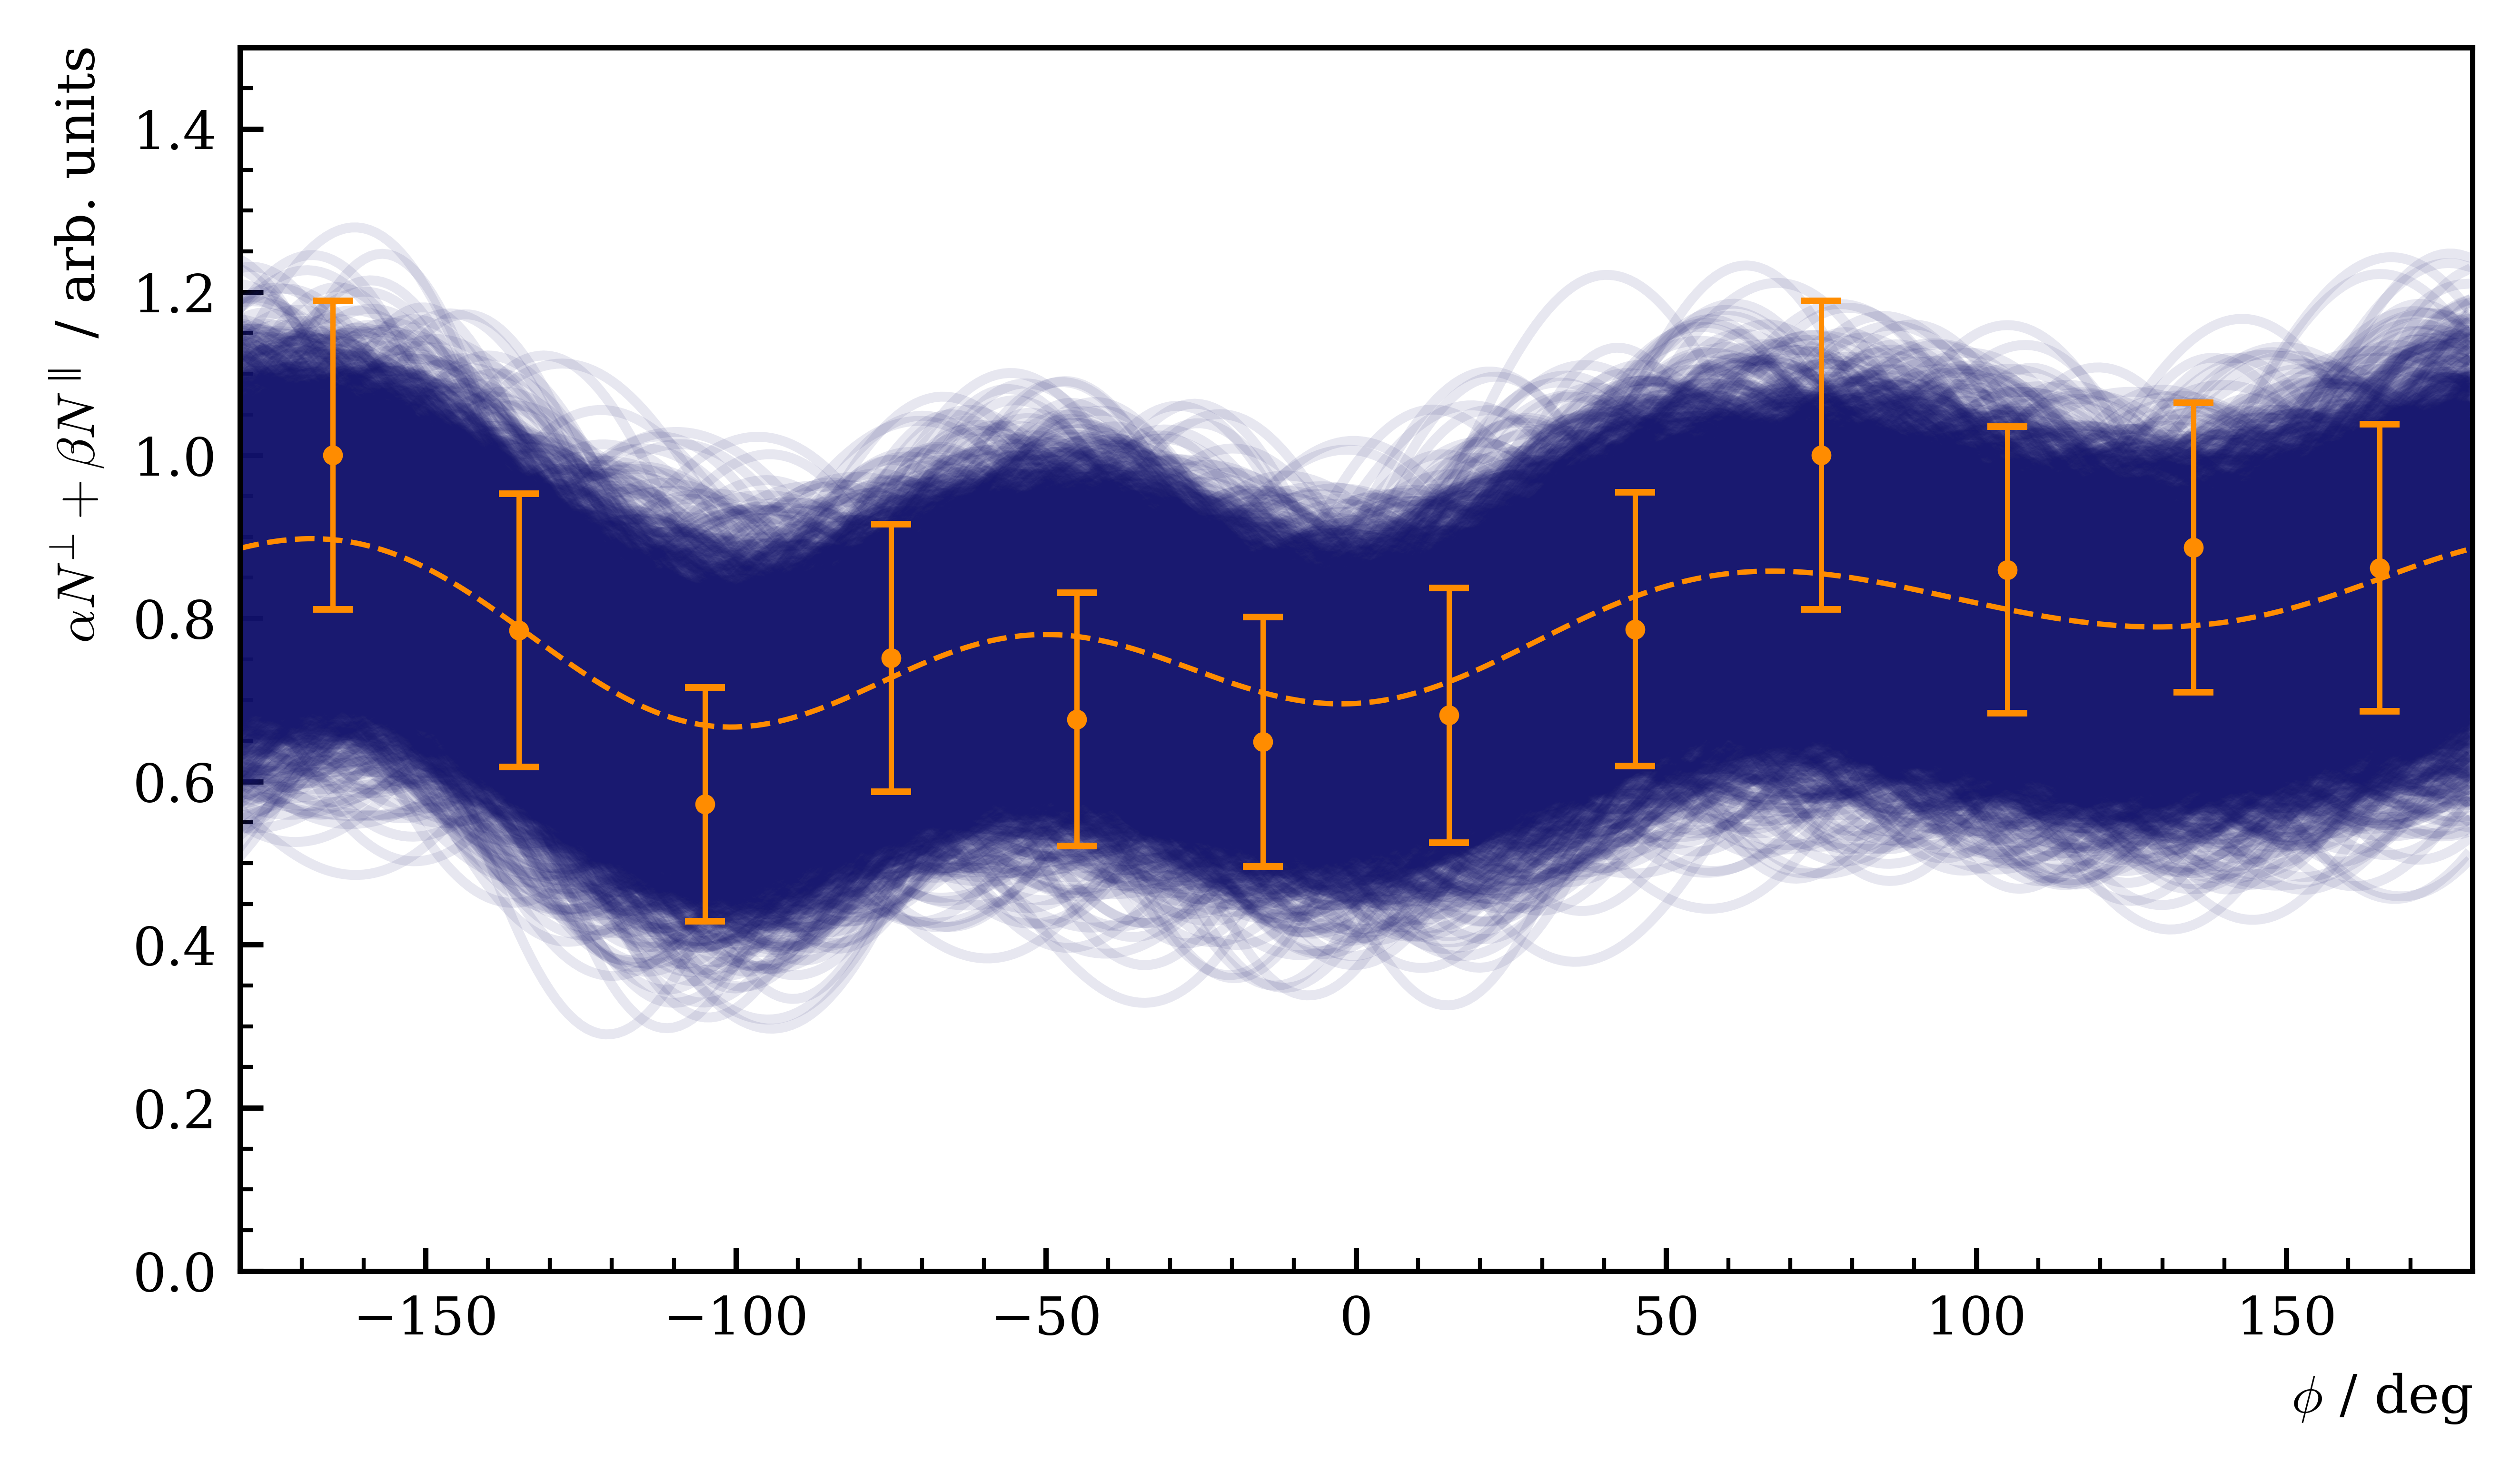

In [3]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
#read data
i=2 # define which bin to use
j=5
samples=pd.read_csv(f'samples_ebin{i:02d}costbin{j:02d}.csv',index_col=0)
summary=pd.read_csv(f'summary_ebin{i:02d}costbin{j:02d}.csv',index_col=0)

df=pd.read_csv(f"ebin{i:02d}/ebin{i:02d}costbin{j:02d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",12,-180,180)
hm45=r.TH1F("m45","m45",12,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)
#build polarization weighted sum
pol_p45=np.abs(np.mean(p45['pol']))
pol_m45=np.abs(np.mean(m45['pol']))
hp45.Add(hp45,hm45,pol_m45/(pol_p45+pol_m45),pol_p45/(pol_m45+pol_p45))
hp45.Scale(1./hp45.GetMaximum())
#write values of histo to numpy array
asym=[]
asym_err=[]
phi=[]
for i in range(hp45.GetNbinsX()):
    asym.append(hp45.GetBinContent(i+1))
    asym_err.append(hp45.GetBinError(i+1))
    phi.append(hp45.GetBinCenter(i+1))
asym=np.array(asym)
asym_err=np.array(asym_err)
phi=np.array(phi)
xx=np.arange(-180,180)

#plot results
fig, ax = plt.subplots(figsize=[15.3728/2.54,8.6472/2.54],dpi=1000)
ax.errorbar(x=phi,y=asym,yerr=asym_err,fmt='.',color='darkorange',zorder=3,label='data',elinewidth=0.8,markersize=4)
#get ALL values of fourier coeff
eff_list=[]
for i in range(4000):
    #get mean values of fourier coeff
    tmp_a=[samples[f'a[{j+1}]'][i] for j in range(4)]
    tmp_b=[samples[f'b[{j+1}]'][i] for j in range(4)]
    #put them in efficiency function
    def tmp_eff(x,c):
        val=1 # a0=0,b0=1
        for i in range(4):
            val+=tmp_a[i]*np.sin((i+1)*x*np.pi/180)+tmp_b[i]*np.cos((i+1)*x*np.pi/180)
        return c*val 
    popt,pcov = curve_fit(tmp_eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
    eff_list.append(tmp_eff(xx,popt))
    #ax.plot(xx,eff(xx,popt),color='midnightblue',alpha=0.5)
for i in range(4000):
    if(i==0):
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.1,label='PPC')
    else:
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.1)
#get mean values of fourier coeff
a=[summary['Mean'][f'a[{i+1}]'] for i in range(4)]
b=[summary['Mean'][f'b[{i+1}]'] for i in range(4)]
#put them in efficiency function
def eff(x,c):
    val=1 # a0=0,b0=1
    for i in range(4):
        val+=a[i]*np.sin((i+1)*x*np.pi/180)+b[i]*np.cos((i+1)*x*np.pi/180)
    return c*val 
popt,pcov = curve_fit(eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
ax.plot(xx,eff(xx,popt),color='darkorange',ls='--',label='Mean of PPC',linewidth=0.8)
ax.tick_params(axis='both',which='both',direction='in')

    
    

ax.set_ylim([0,1.5])
ax.set_xlim([-180,180])
ax.set_xlabel("$\phi$ / deg",horizontalalignment='right',x=1.0)
ax.set_ylabel(r"$\alpha N^{\bot} + \beta N^{\parallel} $ / arb. units",horizontalalignment='right',y=1.0)
ax.grid(False)
#plt.legend()
plt.show()
fig.savefig('./plots/eff_PPC.png',format='png',dpi=1000,bbox_inches='tight')